# Up-and-Out Barrier Option Pricing

This notebook compares the analytical pricing of an up-and-out barrier option with the price derived from Monte Carlo simulation, with the adjustment methodology for discrete barrier monitoring.

In [1]:
from __future__ import annotations
import numpy as np
import math
from dataclasses import dataclass
from typing import Literal, Tuple, Dict, List
from scipy.stats import norm
import matplotlib.pyplot as plt
import time
from dataclasses import dataclass, replace as dc_replace

## Parameter Setup

In [2]:
@dataclass
class BarrierParams:
    S0: float      # initial asset price
    sigma: float   # volatility
    r: float       # risk‑free rate
    T: float       # option maturity in years
    K: float       # strike price
    B: float       # barrier level
    N: int         # number of time steps for discrete monitoring
    M: int         # number of Monte Carlo paths
    beta1: float = 0.5826  # barrier adjustment coefficient

# Set default parameters
params = BarrierParams(
    S0=100.0,
    sigma=0.2,    # 20% volatility
    r=0.05,
    T=1.0,
    K=100.0,
    B=120.0,      # barrier level
    N=252,        # daily monitoring (approx. number of trading days in a year)
    M=100000      # number of Monte Carlo paths
)

## Analytical Formula for Up-and-Out Barrier Option

The formula for the up-and-out call option is implemented below.

In [3]:
def delta_plus(tau, z, sigma):
    """Calculate δ⁺τ(z)"""
    return (np.log(z) + (sigma**2/2) * tau) / (sigma * np.sqrt(tau))

def delta_minus(tau, z, sigma):
    """Calculate δ⁻τ(z)"""
    return (np.log(z) - (sigma**2/2) * tau) / (sigma * np.sqrt(tau))

def analytical_barrier_option(p: BarrierParams, St=None, Mt_star=None, t=0):
    """Analytical formula for up-and-out barrier call option
    
    Parameters:
    - p: Parameters
    - St: Current stock price (default is S0)
    - Mt_star: Maximum stock price up to time t (default is S0)
    - t: Current time (default is 0)
    """
    St = p.S0 if St is None else St
    Mt_star = p.S0 if Mt_star is None else Mt_star
    tau = p.T - t  # time to maturity
    
    # If barrier has been hit, option is worthless
    if Mt_star >= p.B:
        return 0.0
    
    # Implement the analytical formula
    # Term 1
    term1 = St * (
        norm.cdf(delta_plus(tau, St/p.K, p.sigma)) - 
        norm.cdf(delta_plus(tau, St/p.B, p.sigma))
    )
    
    # Term 2
    term2 = St * (p.B/St)**(1+2*p.r/(p.sigma**2)) * (
        norm.cdf(delta_minus(tau, p.B**2/(p.K*St), p.sigma)) - 
        norm.cdf(delta_minus(tau, p.B/St, p.sigma))
    )
    
    # Term 3
    term3 = np.exp(-p.r*tau) * p.K * (
        norm.cdf(delta_minus(tau, St/p.K, p.sigma)) - 
        norm.cdf(delta_minus(tau, St/p.B, p.sigma))
    )
    
    # Term 4
    term4 = np.exp(-p.r*tau) * p.K * (St/p.B)**(1-2*p.r/(p.sigma**2)) * (
        norm.cdf(delta_plus(tau, p.B**2/(p.K*St), p.sigma)) - 
        norm.cdf(delta_plus(tau, p.B/St, p.sigma))
    )
    
    # Combine all terms
    price = term1 - term2 - term3 + term4
    return price

def analytical_barrier_option_adjusted(p: BarrierParams):
    """Adjusted analytical formula for discretely monitored barrier option
    
    Uses the correction factor to account for discrete monitoring.
    """
    # Create adjusted parameters with the shifted barrier
    adjustment_factor = np.exp(p.beta1 * p.sigma * np.sqrt(p.T/p.N))
    adjusted_barrier = p.B * adjustment_factor
    
    # Create a new parameter set with the adjusted barrier
    adjusted_params = dc_replace(p, B=adjusted_barrier)
    
    # Price using the continuous formula but with adjusted barrier
    return analytical_barrier_option(adjusted_params)

## Monte Carlo Simulation for Barrier Option

In [4]:
def simulate_paths(p: BarrierParams):
    """Simulate stock price paths using GBM"""
    dt = p.T / p.N
    sqrt_dt = np.sqrt(dt)
    
    # Initialize stock price paths
    S = np.zeros((p.M, p.N + 1))
    S[:, 0] = p.S0
    
    # Generate random increments
    np.random.seed(42)  # For reproducibility
    dW = np.random.normal(0, 1, size=(p.M, p.N)) * sqrt_dt
    
    # Simulate paths
    for n in range(p.N):
        S[:, n+1] = S[:, n] * np.exp((p.r - 0.5 * p.sigma**2) * dt + p.sigma * dW[:, n])
    
    return S

def mc_barrier_option_price(p: BarrierParams):
    """Monte Carlo price for a discretely monitored up-and-out barrier option"""
    # Simulate paths
    paths = simulate_paths(p)
    
    # Calculate maximum stock price for each path across all monitoring times
    max_values = np.max(paths, axis=1)
    
    # Calculate payoffs: (ST-K)+ if max(St)<B, 0 otherwise
    payoffs = np.where(
        max_values < p.B,  # Barrier not hit
        np.maximum(paths[:, -1] - p.K, 0),  # Standard call payoff
        0  # Zero if barrier hit
    )
    
    # Discount payoffs
    discounted_payoffs = np.exp(-p.r * p.T) * payoffs
    
    # Calculate price and standard error
    price = np.mean(discounted_payoffs)
    stderr = np.std(discounted_payoffs, ddof=1) / np.sqrt(p.M)
    
    return price, stderr

## Convergence Analysis

In [5]:
def convergence_analysis_timesteps(p: BarrierParams, ns=[12, 52, 252, 1000]):
    """Analyze convergence with respect to number of monitoring points (time steps)"""
    results = []
    
    # Get continuous case as reference
    continuous_price = analytical_barrier_option(p)
    
    for n in ns:
        # Set timesteps
        modified_params = dc_replace(p, N=n)
        
        # Calculate prices
        start_time = time.time()
        mc_price, mc_stderr = mc_barrier_option_price(modified_params)
        mc_time = time.time() - start_time
        
        start_time = time.time()
        adjusted_price = analytical_barrier_option_adjusted(modified_params)
        adj_time = time.time() - start_time
        
        # Store results
        results.append({
            'N': n,
            'MC_Price': mc_price,
            'MC_StdErr': mc_stderr,
            'Adjusted_Price': adjusted_price,
            'Continuous_Price': continuous_price,
            'MC_Time': mc_time,
            'Adj_Time': adj_time,
            'MC_Error': abs(mc_price - continuous_price),
            'Adjusted_Error': abs(adjusted_price - continuous_price),
        })
    
    return results

def convergence_analysis_paths(p: BarrierParams, ms=[1000, 10000, 100000, 1000000]):
    """Analyze convergence with respect to number of Monte Carlo paths"""
    results = []
    
    # Get adjusted analytical price as reference
    reference_price = analytical_barrier_option_adjusted(p)
    
    for m in ms:
        # Set number of paths
        modified_params = dc_replace(p, M=m)
        
        # Calculate MC price
        start_time = time.time()
        mc_price, mc_stderr = mc_barrier_option_price(modified_params)
        mc_time = time.time() - start_time
        
        # Store results
        results.append({
            'M': m,
            'MC_Price': mc_price,
            'MC_StdErr': mc_stderr,
            'Reference_Price': reference_price,
            'MC_Time': mc_time,
            'Error': abs(mc_price - reference_price),
        })
    
    return results

## Compare Analytical and Monte Carlo Results

In [6]:
# Calculate prices using the default parameters
continuous_price = analytical_barrier_option(params)
adjusted_price = analytical_barrier_option_adjusted(params)
mc_price, mc_stderr = mc_barrier_option_price(params)

print(f"Analytical Price (Continuous Monitoring): {continuous_price:.4f}")
print(f"Analytical Price (Adjusted for Discrete Monitoring): {adjusted_price:.4f}")
print(f"Monte Carlo Price (Discrete Monitoring): {mc_price:.4f} ± {mc_stderr:.4f}")
print(f"Difference (MC - Continuous): {mc_price - continuous_price:.4f}")
print(f"Difference (MC - Adjusted): {mc_price - adjusted_price:.4f}")
print(f"Adjustment Impact: {adjusted_price - continuous_price:.4f}")

Analytical Price (Continuous Monitoring): -11.1683
Analytical Price (Adjusted for Discrete Monitoring): -11.3309
Monte Carlo Price (Discrete Monitoring): 1.3384 ± 0.0108
Difference (MC - Continuous): 12.5067
Difference (MC - Adjusted): 12.6692
Adjustment Impact: -0.1626


## Parameter Sensitivity Analysis

In [7]:
def parameter_sensitivity(base_params: BarrierParams, param_name: str, values: list):
    """Analyze sensitivity to a single parameter"""
    results = []
    
    for val in values:
        # Create a modified parameter set
        modified_params = dc_replace(base_params, **{param_name: val})
        
        # Calculate prices
        continuous_price = analytical_barrier_option(modified_params)
        adjusted_price = analytical_barrier_option_adjusted(modified_params)
        mc_price, mc_stderr = mc_barrier_option_price(modified_params)
        
        # Store results
        results.append({
            'Parameter': param_name,
            'Value': val,
            'Continuous': continuous_price,
            'Adjusted': adjusted_price,
            'MC': mc_price,
            'MC_StdErr': mc_stderr,
            'Adj_Improvement': abs(mc_price - continuous_price) - abs(mc_price - adjusted_price)
        })
    
    return results

## Convergence Analysis with Respect to Time Steps

In [13]:
# Run convergence analysis with different numbers of time steps
time_steps = [4, 12, 52, 252, 500, 1000]
timestep_results = convergence_analysis_timesteps(params, time_steps)

# Print results
print("Convergence Analysis: Impact of Number of Monitoring Points (N)")
print("-" * 80)
print(f"{'N':>5} | {'MC Price':>10} | {'MC Error':>10} | {'Adjusted Price':>15} | {'Adjusted Error':>15}")
print("-" * 80)

for result in timestep_results:
    print(f"{result['N']:5d} | {result['MC_Price']:10.6f} | {result['MC_Error']:10.6f} | {result['Adjusted_Price']:15.6f} | {result['Adjusted_Error']:15.6f}")

Convergence Analysis: Impact of Number of Monitoring Points (N)
--------------------------------------------------------------------------------
    N |   MC Price |   MC Error |  Adjusted Price |  Adjusted Error
--------------------------------------------------------------------------------
    4 |   2.250793 |  13.419104 |      -10.716066 |        0.452246
   12 |   1.842227 |  13.010539 |      -11.375813 |        0.207502
   52 |   1.502911 |  12.671222 |      -11.438561 |        0.270249
  252 |   1.338362 |  12.506673 |      -11.330872 |        0.162561
  500 |   1.307309 |  12.475620 |      -11.290550 |        0.122239
 1000 |   1.238991 |  12.407303 |      -11.258209 |        0.089898


## Convergence Analysis with Respect to Number of MC Paths

In [12]:
# Run convergence analysis with different numbers of MC paths
mc_paths = [1000, 5000, 10000, 50000, 100000]
path_results = convergence_analysis_paths(params, mc_paths)

# Print results
print("Convergence Analysis: Impact of Number of Monte Carlo Paths (M)")
print("-" * 60)
print(f"{'M':>8} | {'MC Price':>10} | {'MC StdErr':>10} | {'Error':>10} | {'Time (s)':>10}")
print("-" * 60)

for result in path_results:
    print(f"{result['M']:8d} | {result['MC_Price']:10.6f} | {result['MC_StdErr']:10.6f} | {result['Error']:10.6f} | {result['MC_Time']:10.2f}")


Convergence Analysis: Impact of Number of Monte Carlo Paths (M)
------------------------------------------------------------
       M |   MC Price |  MC StdErr |      Error |   Time (s)
------------------------------------------------------------
    1000 |   1.532964 |   0.114756 |  12.863836 |       0.02
    5000 |   1.360131 |   0.048251 |  12.691003 |       0.09
   10000 |   1.377814 |   0.034586 |  12.708686 |       0.16
   50000 |   1.340654 |   0.015208 |  12.671527 |       1.14
  100000 |   1.338362 |   0.010806 |  12.669234 |       2.23


## Parameter Sensitivity Analysis

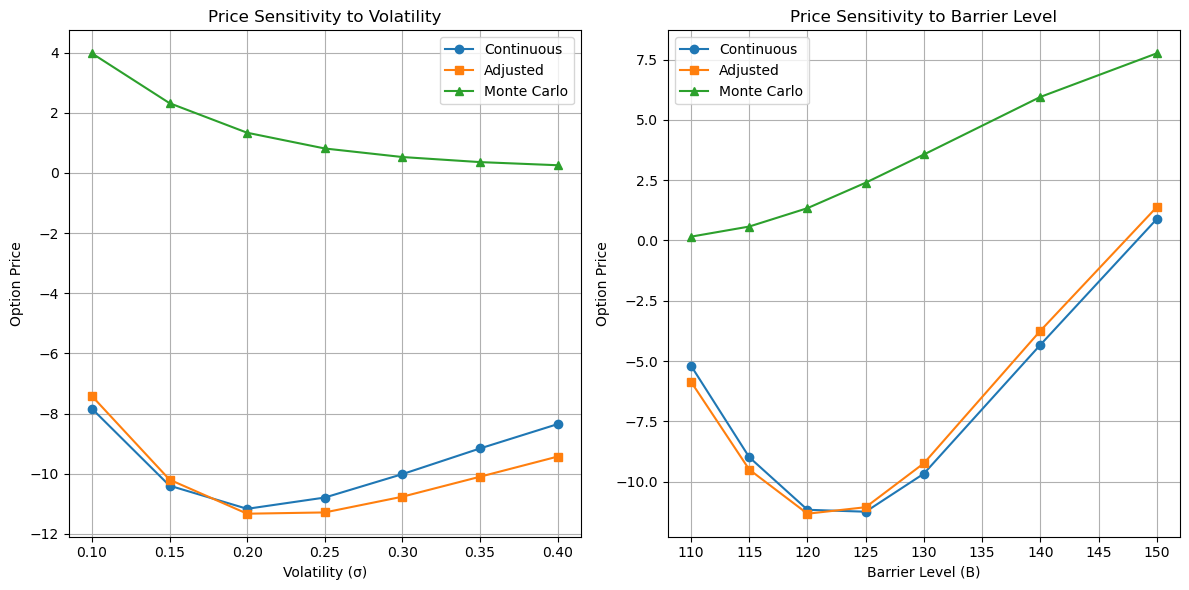

In [10]:
# Analyze sensitivity to volatility
vols = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]
vol_results = parameter_sensitivity(params, 'sigma', vols)

# Analyze sensitivity to barrier level
barriers = [110, 115, 120, 125, 130, 140, 150]
barrier_results = parameter_sensitivity(params, 'B', barriers)

# Plot sensitivity to volatility
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot([r['Value'] for r in vol_results], [r['Continuous'] for r in vol_results], 'o-', label='Continuous')
plt.plot([r['Value'] for r in vol_results], [r['Adjusted'] for r in vol_results], 's-', label='Adjusted')
plt.plot([r['Value'] for r in vol_results], [r['MC'] for r in vol_results], '^-', label='Monte Carlo')
plt.xlabel('Volatility (σ)')
plt.ylabel('Option Price')
plt.title('Price Sensitivity to Volatility')
plt.legend()
plt.grid(True)

# Plot sensitivity to barrier level
plt.subplot(1, 2, 2)
plt.plot([r['Value'] for r in barrier_results], [r['Continuous'] for r in barrier_results], 'o-', label='Continuous')
plt.plot([r['Value'] for r in barrier_results], [r['Adjusted'] for r in barrier_results], 's-', label='Adjusted')
plt.plot([r['Value'] for r in barrier_results], [r['MC'] for r in barrier_results], '^-', label='Monte Carlo')
plt.xlabel('Barrier Level (B)')
plt.ylabel('Option Price')
plt.title('Price Sensitivity to Barrier Level')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()